#  Based On Given Data We have to classify it as a Fraud Or Not

 ## Data has a transaction set and Identity set

### Transaction Table

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain 
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is       masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD,
card1 - card6
addr1, addr2
Pemaildomain Remaildomain,
M1 - M9,
Devicetype,
DeviceInfo.

### Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:

DeviceType

DeviceInfo

id12 - id38

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.gridspec as gridspec
# init_notebook_mode(connected=True)
# cufflinks.go_offline(connected=True)


In [3]:
import gc
gc.enable()
import logging 
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
# Standard plotly imports
import plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff


In [6]:
import pandas as pd
import os
import numpy as np


In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
train_identity = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\train_identity.csv", index_col='TransactionID')

In [8]:
train_transaction = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\train_transaction.csv",index_col='TransactionID')

In [9]:
test_identity = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\test_identity.csv",index_col='TransactionID')

In [10]:
test_transaction = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\test_transaction.csv",index_col='TransactionID')

#  index_col='TransactionID'

In [8]:
print('# File sizes')
for f in os.listdir("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION"):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\'+ f) / 1000000, 2)) + 'MB')

# D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION

# File sizes
fraud-detection-master        0.0MB
sample_submission.csv         6.08MB
test_identity.csv             25.8MB
test_transaction.csv          613.19MB
train_identity.csv            26.53MB
train_transaction.csv         683.35MB


In [13]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [14]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
TransactionID                                                                 
2987000        150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
2987001        150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2987002        150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
2987003        150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
2987004        150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

              P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
TransactionID                                                                  
2987000                 NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987001           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987002         outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987003           yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
2987004           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   

                C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4  \
TransactionID                                                                 
2987000        0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN   
2987001        0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987002        0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987003        0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0   
2987004        1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   

                D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15   M1  \
TransactionID                                                                
2987000        NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0    T   
2987001        NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN   
2987002        NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0    T   
2987003        0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN  111.0  NaN   
2987004        NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN    NaN  NaN   

                M2   M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4  \
TransactionID                                                               
2987000          T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
2987001        NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987002          T    T   M0    F    F    F    F    F  1.0  1.0  1.0  1.0   
2987003        NaN  NaN   M0    T    F  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  \
TransactionID                                                               
2987000        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987001        NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0   
2987002        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987003        NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
TransactionID                                                             

In [67]:
train_transaction.shape

(590540, 393)

In [15]:
train_identity.head()

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

               id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  \
TransactionID                                                                 
2987004          NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound   
2987008          NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound   
2987010          0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found   
2987011          NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound   
2987016          0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found   

               id_17  id_18  id_19  id_20  id_21  id_22 id_23  id_24  id_25  \
TransactionID                                                                 
2987004        166.0    NaN  542.0  144.0    NaN    NaN   NaN    NaN    NaN   
2987008        166.0    NaN  621.0  500.0    NaN    NaN   NaN    NaN    NaN   
2987010        121.0    NaN  410.0  142.0    NaN    NaN   NaN    NaN    NaN   
2987011        225.0    NaN  176.0  507.0    NaN    NaN   NaN    NaN    NaN   
2987016        166.0   15.0  529.0  575.0    NaN    NaN   NaN    NaN    NaN   

               id_26 id_27  id_28     id_29             id_30  \
TransactionID                                                   
2987004          NaN   NaN    New  NotFound       Android 7.0   
2987008          NaN   NaN    New  NotFound        iOS 11.1.2   
2987010          NaN   NaN  Found     Found               NaN   
2987011          NaN   NaN    New  NotFound               NaN   
2987016          NaN   NaN  Found     Found  Mac OS X 10_11_6   

                             id_31  id_32      id_33           id_34 id_35  \
TransactionID                                                                
2987004        samsung browser 6.2   32.0  2220x1080  match_status:2     T   
2987008         mobile safari 11.0   32.0   1334x750  match_status:1     T   
2987010                chrome 62.0    NaN        NaN             NaN     F   
2987011                chrome 62.0    NaN        NaN             NaN     F   
2987016                chrome 62.0   24.0   1280x800  match_status:2     T   

              id_36 id_37 id_38 DeviceType                     DeviceInfo  
TransactionID                                                              
2987004           F     T     T     mobile  SAMSUNG SM-G892A Build/NRD90M  
2987008           F     F     T     mobile                     iOS Device  
2987010           F     T     T    desktop                        Windows  
2987011           F     T     T    desktop                            NaN  
2987016           F     T     T    desktop                          MacOS



OK, there are a lot of NaN and interesting columns:

C1, C2 ... D1, V300, V339 ...
id_01 ... id_38
The columns with those names don't look friendly. Apparently we don't have dates.

#### 1st problem: NaN
Remember

Not all transactions have corresponding identity information




In [36]:
missing_value_counts = train_transaction.isnull().sum()
print(missing_value_counts[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_value_counts.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


In [13]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [38]:
del missing_values_count, total_cells, total_missing

### 2nd Problem is Imbalanced Data

In [16]:
x = train_transaction['isFraud'].value_counts().index
y = train_transaction['isFraud'].value_counts().values

In [17]:
trace2 = go.Bar(x=x,y=y, marker=dict(color=y,colorscale = 'Viridis',reversescale = True), name="Imbalance",)
layout = dict(     title="Data imbalance - isFraud",width = 900, height = 500,xaxis=go.layout.XAxis(automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)
 

In [41]:
y

array([569877,  20663], dtype=int64)

In [19]:
del x,y 
gc.collect

<function gc.collect(generation=2)>

### <span style="color:indianred"> Time Series Analysis</span>

The train and test data appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time.

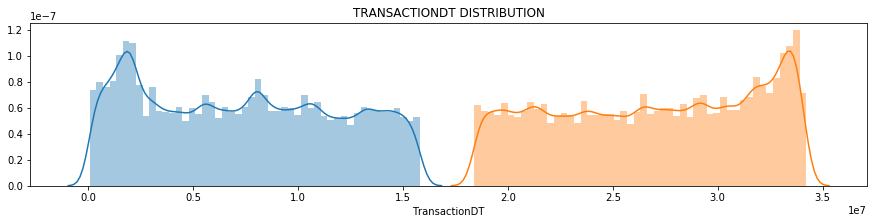

In [22]:
plt.figure(figsize=(15,3))
plt.title('TRANSACTIONDT DISTRIBUTION')

ax = sns.distplot(train_transaction.TransactionDT,kde = True,hist= True)
ax = sns.distplot(test_transaction.TransactionDT,kde = True,hist= True)

## <span style="color:indianred">TransactionAmt</span>

Since the data was skewed to right, log transform was used to center the data over orders of magnitudes. <br>
It seems that the mean fraud transaction amount is higher than non-fraud transaction amount.


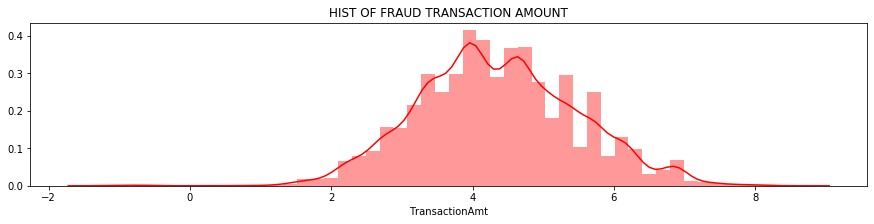

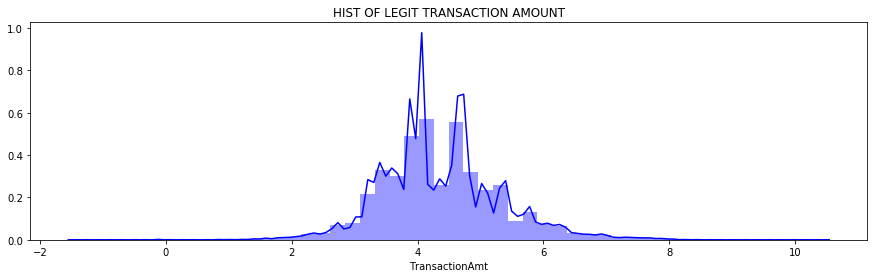

In [32]:
plt.figure(figsize = (15,3))
plt.title('HIST OF FRAUD TRANSACTION AMOUNT')
ax = sns.distplot(train_transaction.loc[train_transaction["isFraud"]==1].TransactionAmt.apply(np.log), color = 'r', kde = True)

plt.figure(figsize=(15,4))
plt.title("HIST OF LEGIT TRANSACTION AMOUNT")
ax = sns.distplot(train_transaction.loc[train_transaction["isFraud"]==0].TransactionAmt.apply(np.log), color="b", kde=True)

In [34]:
print("Mean fraud amount : %.2f"%train_transaction.loc[train_transaction["isFraud"] == 1].TransactionAmt.mean())
print("Mean legit amount : %.2f"%train_transaction.loc[train_transaction["isFraud"] == 0].TransactionAmt.mean())

Mean fraud amount : 149.24
Mean legit amount : 134.51


## <span style="color:indianred">ProductCD</span>

In the overall training data, W and C counts are high. <br>
When the percentage of fraud from each product is taken into consideration, C dominates. <br>
W is around 74% <br>

In [37]:
train_transaction['ProductCD'].value_counts()/train_transaction['ProductCD'].value_counts().sum()

W    0.744522
C    0.116028
R    0.063838
H    0.055922
S    0.019690
Name: ProductCD, dtype: float64

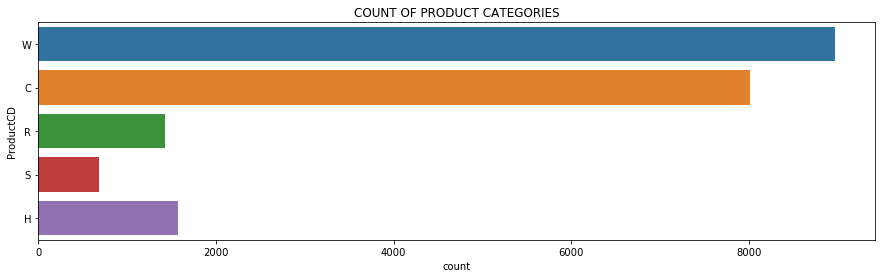

In [39]:
plt.figure(figsize=(15,4))
plt.title("COUNT OF PRODUCT CATEGORIES")

ax = sns.countplot(y=train_transaction.loc[train_transaction["isFraud"] == 1].ProductCD)

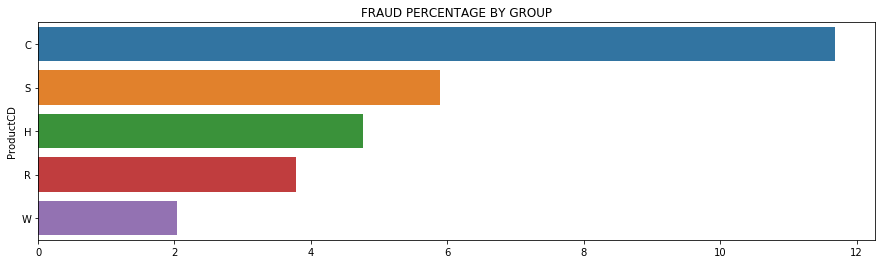

In [24]:
plt.figure(figsize=(15,4))
plt.title("FRAUD PERCENTAGE BY GROUP")

percent = (train_transaction.groupby("ProductCD")["isFraud"].mean()*100).sort_values(ascending=False)
ax = sns.barplot(y=percent.index, x=percent.values)

# del percent

In [26]:
percent # of which are positive examples

ProductCD
C    11.687269
S     5.899553
H     4.766231
R     3.782594
W     2.039939
Name: isFraud, dtype: float64

## <span style="color:indianred">card_1 - card_6</span>

card_1 to card_6 are given to be categorical, even though some appear continuous <br>
card_4 seems to represent vendor company <br>
card_6 seems to represent the card type (credit or debit) <br>

In [59]:
card_cols = [c for c in train_transaction.columns  if "card" in c]
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
TransactionID                                                
2987000        13926    NaN  150.0    discover  142.0  credit
2987001         2755  404.0  150.0  mastercard  102.0  credit
2987002         4663  490.0  150.0        visa  166.0   debit
2987003        18132  567.0  150.0  mastercard  117.0   debit
2987004         4497  514.0  150.0  mastercard  102.0  credit

In [29]:
# List of matplotlib colors to use in iteration
mat_colors = ["teal", "olive", "blue", "maroon", "green", "purple", "red", "orangered", "tan"] 

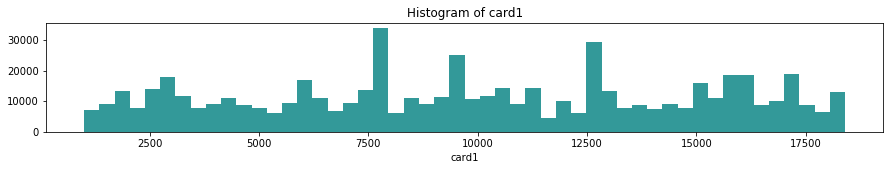

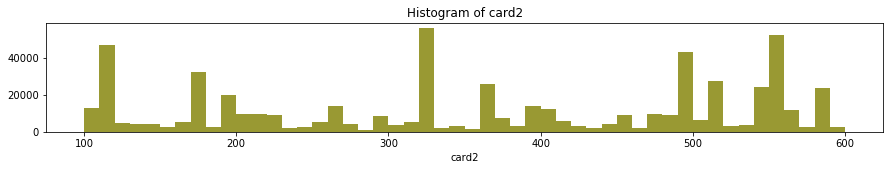

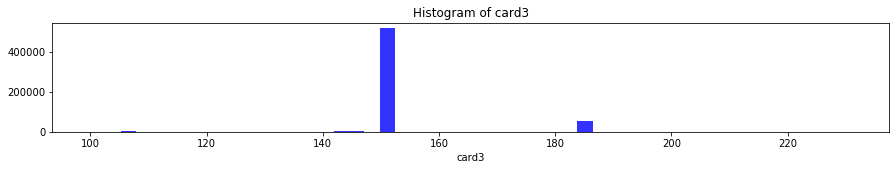

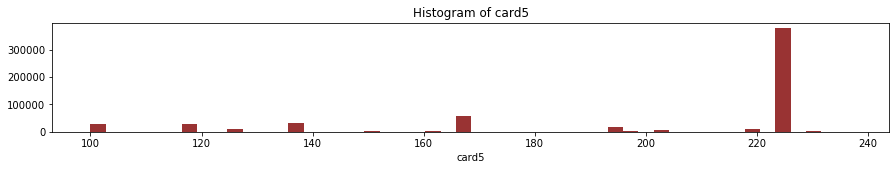

In [30]:
color_id = 0

for col in ["card1", "card2", "card3", "card5"]:
    # set individual figure for each column
    plt.figure(figsize=(15, 2))
    plt.title("Histogram of " + str(col))
    
    ax = sns.distplot(train_transaction[col], kde=False, color=mat_colors[color_id], hist_kws={"alpha":0.8})
    
    # update color index
    color_id = (color_id + 1) % len(mat_colors)

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

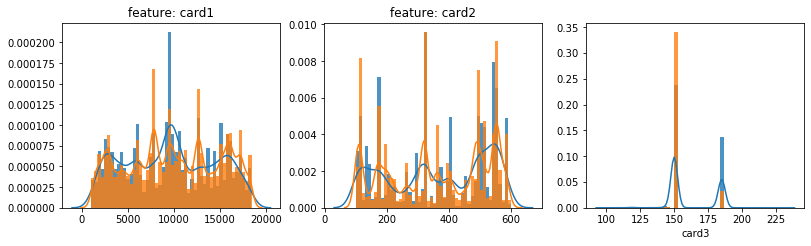

In [16]:
cards = train_transaction.iloc[:,4:7].columns

plt.figure(figsize=(18,8*4))
gs = gridspec.GridSpec(8, 4)
for i, cn in enumerate(cards):
    ax = plt.subplot(gs[i])
    sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 1][cn], bins=50,hist_kws={"alpha":0.8})
    sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 0][cn], bins=50,hist_kws={"alpha":0.8})
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()


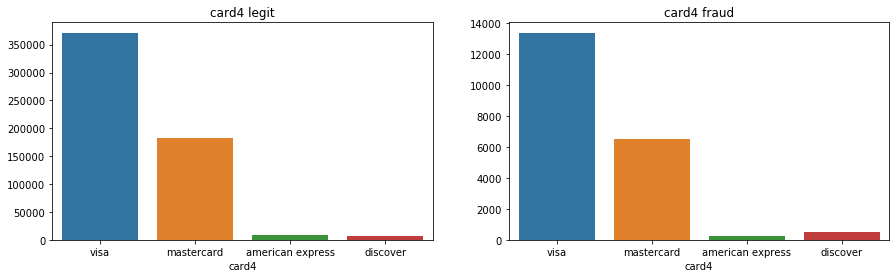

In [64]:
# card4 vs non fraud
# interesting notation when Im doing groupby.sum it is calulating only for isFraud==1


card4group = train_transaction.groupby('card4')['isFraud']
card4order = train_transaction['card4'].value_counts().index

card4_fr = card4group.sum()
card4_lg = card4group.count() - card4_fr    # counts takes the count of all the 0s and 1s

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ax = sns.barplot(card4_lg.index, card4_lg.values, ax=axes[0], order = card4order).set_title("card4 legit")
ax = sns.barplot(card4_fr.index, card4_fr.values, ax=axes[1], order = card4order).set_title("card4 fraud")

del card4group, card4order, card4_fr, card4_lg, fig, axes

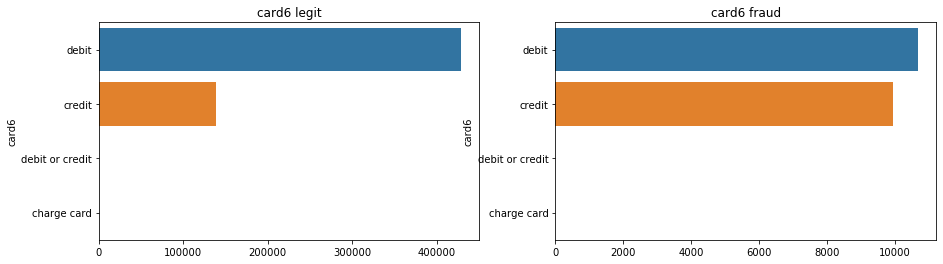

In [66]:
# card6 vs non fraud
# interesting notation when Im doing groupby.sum it is calulating only for isFraud==1

card6group = train_transaction.groupby('card6')['isFraud']
card6order = train_transaction['card6'].value_counts().index

card6_fr = card6group.sum()
card6_lg = card6group.count() - card6_fr    # counts takes the count of all the 0s and 1s

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ax = sns.barplot(y = card6_lg.index, x = card6_lg.values, ax=axes[0], order = card6order).set_title("card6 legit")
ax = sns.barplot(y = card6_fr.index, x = card6_fr.values, ax=axes[1], order = card6order).set_title("card6 fraud")

del card6group, card6order, card6_fr, card6_lg, fig, axes

In [49]:
card4_fr = card4group.count()
# card4_lg = card4_group.count() - card4_fr
card4_fr

card4
american express      8328
discover              6651
mastercard          189217
visa                384767
Name: isFraud, dtype: int64

## <span style="color:indianred">P and R emaildomain</span>

These represent purchaser and recipient email domains <br>


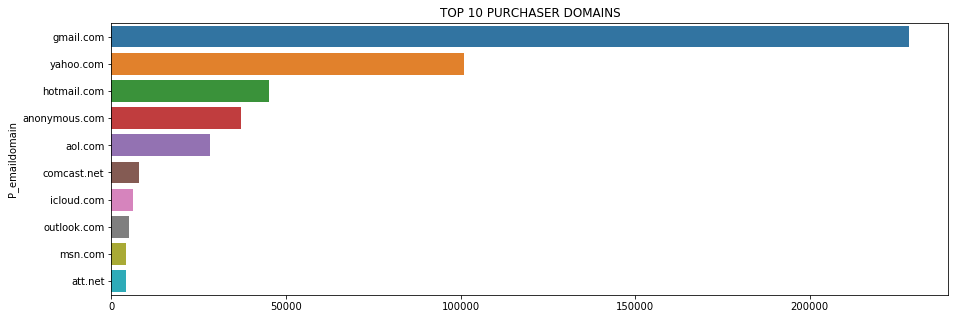

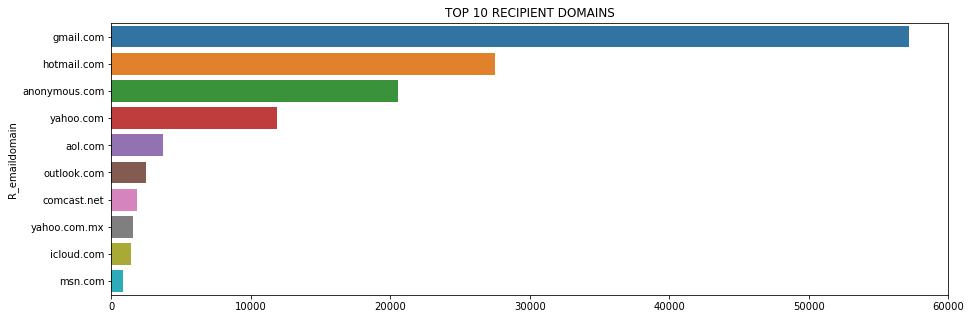

In [20]:
# get top 10 recurring domains
top_p_domains = train_transaction.groupby("P_emaildomain")["TransactionID"].count().sort_values(ascending=False).head(10)
top_r_domains = train_transaction.groupby("R_emaildomain")["TransactionID"].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 5))
plt.title("TOP 10 PURCHASER DOMAINS")
ax = sns.barplot(y=top_p_domains.index, x=top_p_domains.values)

plt.figure(figsize=(15, 5))
plt.title("TOP 10 RECIPIENT DOMAINS")
ax = sns.barplot(y=top_r_domains.index, x=top_r_domains.values)

del top_p_domains, top_r_domains

#####   criminals prefer gmail

## <span style="color:indianred">dist1 - dist2</span>

dist1 and dist2 represent the distance between place of transaction and cardowner's home or work address. <br>
The histogram is justified because most of the transaction happens in the same address <br>

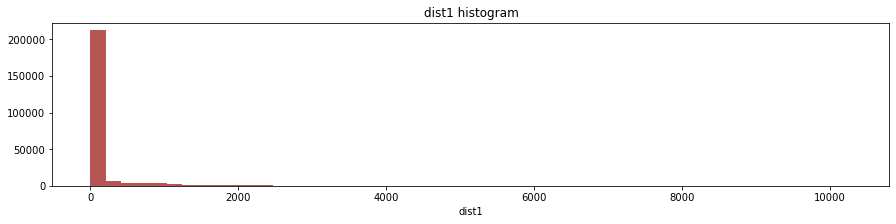

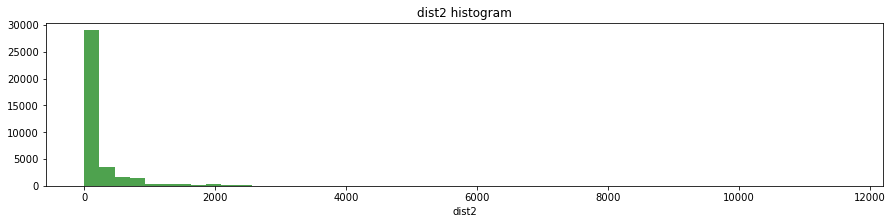

In [10]:
# dist1
plt.figure(figsize=(15, 3))
plt.title("dist1 histogram")
ax = sns.distplot(train_transaction["dist1"], kde=False, color="brown", hist_kws={"alpha":0.8})

# dist2
plt.figure(figsize=(15, 3))
plt.title("dist2 histogram")
ax = sns.distplot(train_transaction["dist2"], kde=False, color="forestgreen", hist_kws={"alpha":0.8})

## <span style="color:indianred">addr1 - addr2</span>

addr1 and addr2 columns are known to be categorical (description). <br>
They represent the address of customer, which is encoded or encrypted for security purposes <br>

In [81]:
print("addr1 contains %d missing values"%train_transaction["addr1"].isna().sum())
print("addr2 contains %d missing values"%train_transaction["addr2"].isna().sum())

addr1 contains 65706 missing values
addr2 contains 65706 missing values


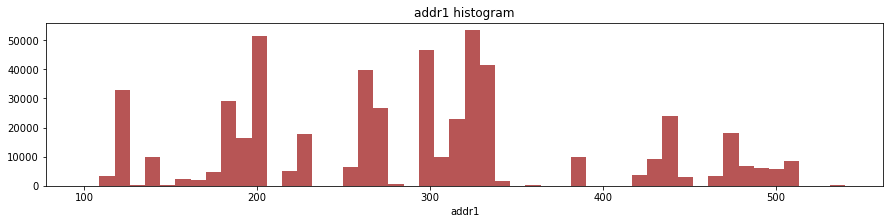

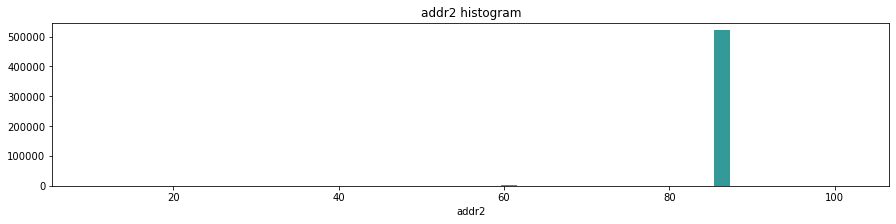

In [84]:
# addr1
plt.figure(figsize=(15, 3))
plt.title("addr1 histogram")
ax = sns.distplot(train_transaction["addr1"], kde=False, color="brown", hist_kws={"alpha":0.8})

# addr2
plt.figure(figsize=(15, 3))
plt.title("addr2 histogram")
ax = sns.distplot(train_transaction["addr2"], kde=False, color="teal", hist_kws={"alpha":0.8})

## <span style="color:indianred">C1 - C14</span>

The columns C1 - C14 are known to be numerical. <br>
Heatmap can be generated to understand correlation between any two variables <br>

In [69]:
c_cols = [col for col in train_transaction.columns if col[0] == 'C']
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
TransactionID                                                               
2987000        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
2987001        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2987002        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987003        2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987004        1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

                C13  C14  
TransactionID             
2987000         1.0  1.0  
2987001         1.0  1.0  
2987002         1.0  1.0  
2987003        25.0  1.0  
2987004         1.0  1.0

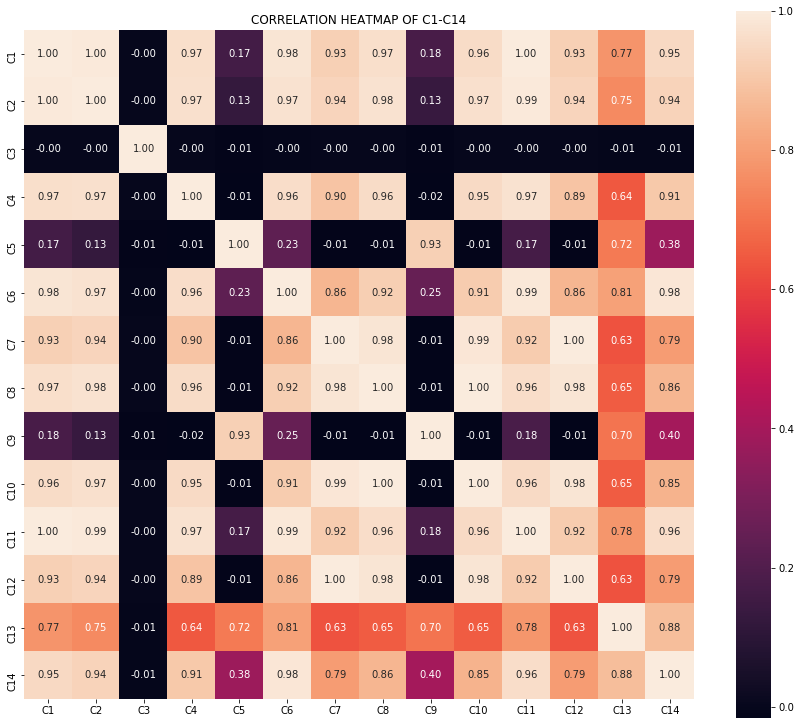

In [71]:
plt.figure(figsize=(15, 13))
plt.title("CORRELATION HEATMAP OF C1-C14")

ax = sns.heatmap(train_transaction[c_cols].corr(), annot=True, fmt=".2f", square=True)

## <span style="color:indianred">D1 - D15</span>

The columns D1 to D15 are also known to be numerical. <br>
Similar heatmap can be generated to better understand correlation between variable pairs. <br>

In [74]:
d_cols = [col for col in train_transaction.columns if col[0] == 'D' and col[1].isdigit()]
train_transaction[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  \
TransactionID                                                               
2987000         14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0   
2987001          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN   
2987002          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0   
2987003        112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN   
2987004          0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN   

               D12  D13  D14    D15  
TransactionID                        
2987000        NaN  NaN  NaN    0.0  
2987001        NaN  NaN  NaN    0.0  
2987002        NaN  NaN  NaN  315.0  
2987003        NaN  NaN  NaN  111.0  
2987004        NaN  NaN  NaN    NaN

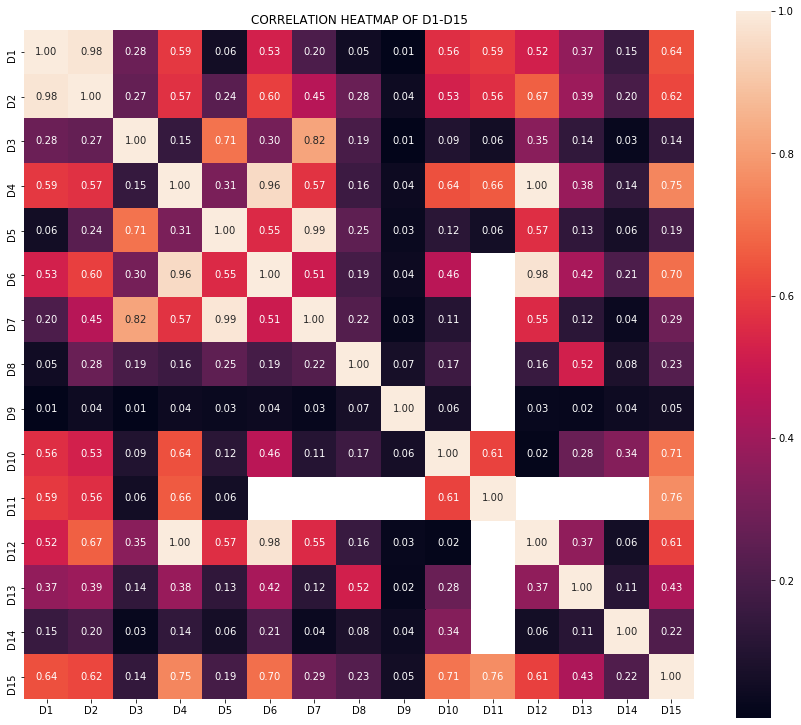

In [75]:
plt.figure(figsize=(15, 13))
plt.title("CORRELATION HEATMAP OF D1-D15")

ax = sns.heatmap(train_transaction[d_cols].corr(), annot=True, fmt=".2f", square=True)

## <span style="color:indianred">M1 - M9</span>

These columns are given to be categorical <br>
M1-M9 except M4 contain - T, F or NaN <br>
M4 contains values  - M0, M1, M2 or NaN <br>

In [65]:
m_cols = [col for col in train_transaction.columns if col[0] == 'M']
train_transaction[m_cols].head()


M1   M2   M3   M4   M5   M6   M7   M8   M9
TransactionID                                             
2987000          T    T    T   M2    F    T  NaN  NaN  NaN
2987001        NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2987002          T    T    T   M0    F    F    F    F    F
2987003        NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

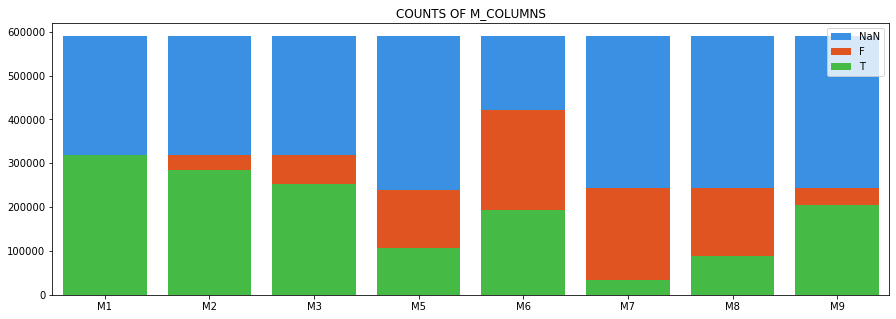

In [66]:
plt.figure(figsize=(15, 5))
plt.title("COUNTS OF M_COLUMNS")

# remove M4 from the list
m_cols = [col for col in m_cols if col != "M4"]

# tru=T, val=T+F, all=val+nan
m_val = train_transaction[m_cols].count()
m_tru = (train_transaction[m_cols] == 'T').sum()
m_all = train_transaction[m_cols].isna().sum() + m_val

# plot
ax = sns.barplot(m_all.index, m_all.values, color="dodgerblue", label="NaN")
ax = sns.barplot(m_val.index, m_val.values, color="orangered", label="F")
ax = sns.barplot(m_tru.index, m_tru.values, color="limegreen", label="T")

# delete unused
del m_val, m_tru, m_all

# set legends and show
ax.legend(ncol = 1, loc = 'upper right')
plt.show()


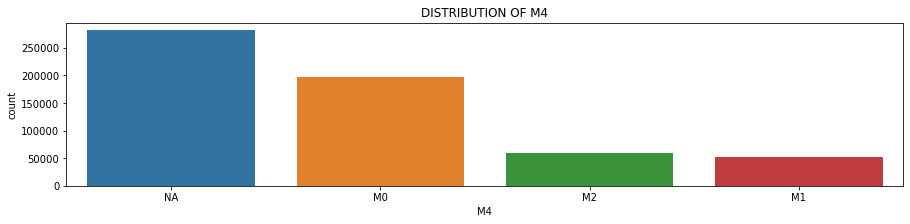

In [13]:
plt.figure(figsize=(15, 3))
plt.title("DISTRIBUTION OF M4")

# ax = sns.countplot(train_transaction["M4"], order=train_transaction["M4"].value_counts().index)
# so the nan values are not shown hence we fill those with a random NA value

train_transaction["M4"] = train_transaction["M4"].fillna("NA")

ax = sns.countplot(train_transaction["M4"], order=train_transaction["M4"].value_counts().index)



## <span style="color:indianred">V1 - V339</span>

These are Vesta engineered columns which are useful features obtained from transforming some features, which may or may not be given. <br>
Simple look at the data reveals that most of them are 0s and 1s with missing values and some larger values as well.

In [24]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  \
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  \
0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  \
0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V91  V92  V93  V94  V95   V96   V97  V98   V99  V100  V101  V102  V103  \
0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  1.0  48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   
4  NaN  NaN  NaN  NaN  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   

   V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  \
0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V116  V117  V118  V119  V120  V121  V122  V123  V124  V125  V126    V127  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0   
1   1.0   1.0   1.0   1.0   1.0   

In [25]:
# create a new columnn with mean of all vs from a row
train_transaction["v_mean"] = train_transaction[v_cols].mean(axis=1)

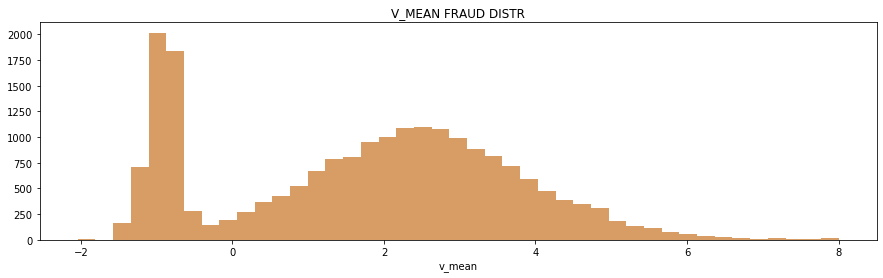

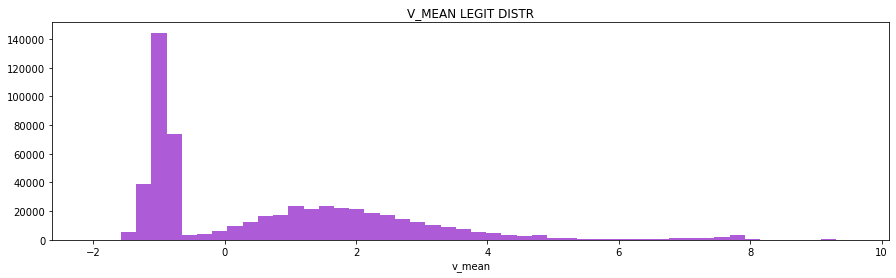

In [29]:
# group and calcuate
v_mean_fr = train_transaction.loc[train_transaction["isFraud"] == 1]["v_mean"].apply(np.log)
v_mean_lg = train_transaction.loc[train_transaction["isFraud"] == 0]["v_mean"].apply(np.log)

# plot
plt.figure(figsize=(15, 4))
plt.title("V_MEAN FRAUD DISTR")
ax = sns.distplot(v_mean_fr, color="peru", kde=False, hist_kws={"alpha":0.8})

plt.figure(figsize=(15, 4))
plt.title("V_MEAN LEGIT DISTR")
ax = sns.distplot(v_mean_lg, color="darkorchid", kde=False, hist_kws={"alpha":0.8})

del v_mean_fr, v_mean_lg

## <span style="color:indianred">DeviceType</span>

The percentage of fraud transactions done by mobile are more than that done by desktops. <br>

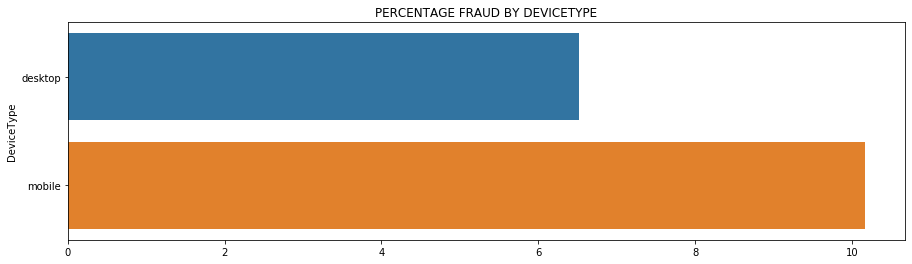

In [33]:
plt.figure(figsize=(15, 4))
plt.title("PERCENTAGE FRAUD BY DEVICETYPE")

if "DeviceType" not in train_transaction.columns:
    train_transaction = train_transaction.merge(train_identity[["TransactionID", "DeviceType"]], on="TransactionID")

device_mean = (train_transaction.groupby("DeviceType")["isFraud"].mean()*100).sort_values()
ax = sns.barplot(y=device_mean.index, x=device_mean.values)

del device_mean

## <span style="color:indianred">DeviceInfo</span>

Without doubt, most transactions occur in Windows clients and iOS, mac follow. <br>

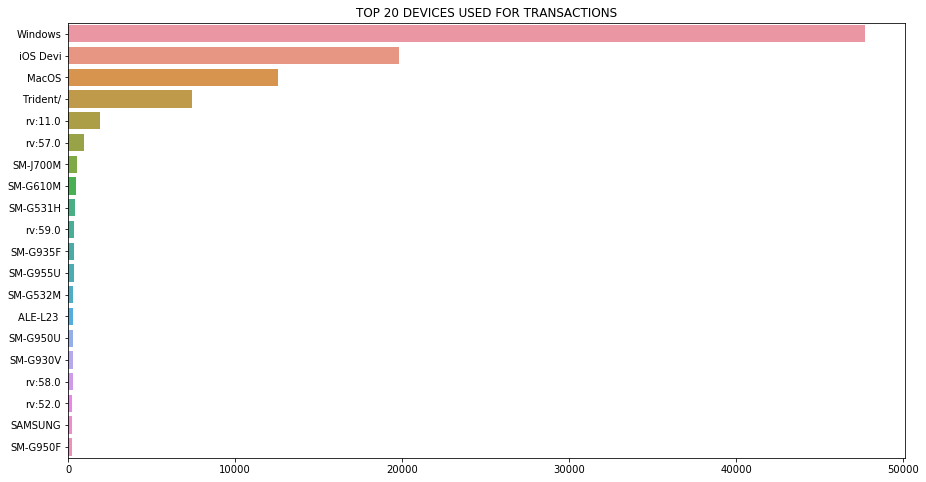

In [45]:
plt.figure(figsize=(15, 8))
plt.title("TOP 20 DEVICES USED FOR TRANSACTIONS")

# get top 20 recurring devices
top_device = train_identity.groupby("DeviceInfo")["TransactionID"].count().sort_values(ascending=False).head(20)
top_device.index = [idx[:8] for idx in top_device.index]

ax = sns.barplot(y=top_device.index, x=top_device.values)

del top_device

## <span style="color:indianred">Some Interesting Data</span>

Plotting some columns that look interesting with respect to Transaction Date to compare Train and Test data values. <br>

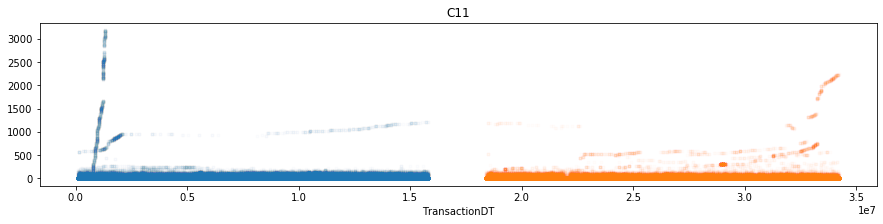

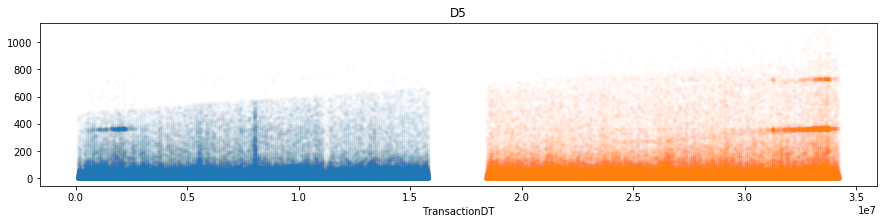

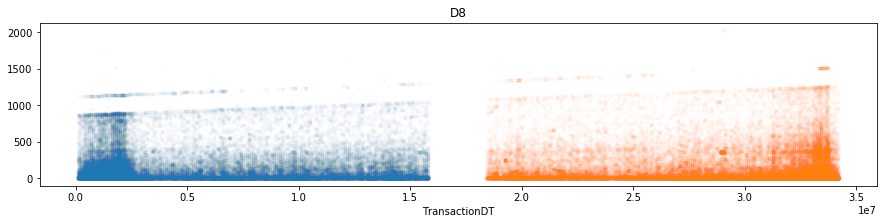

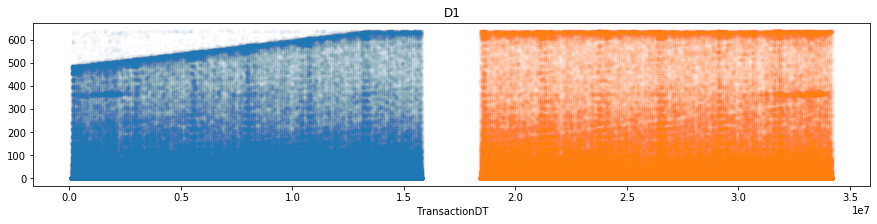

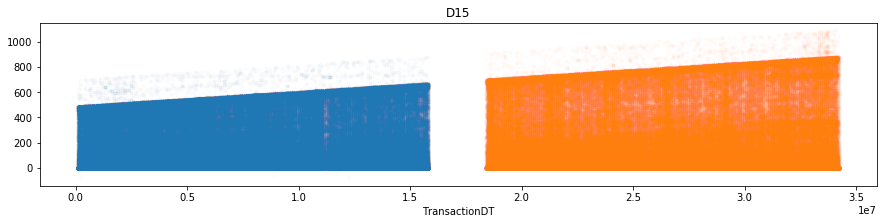

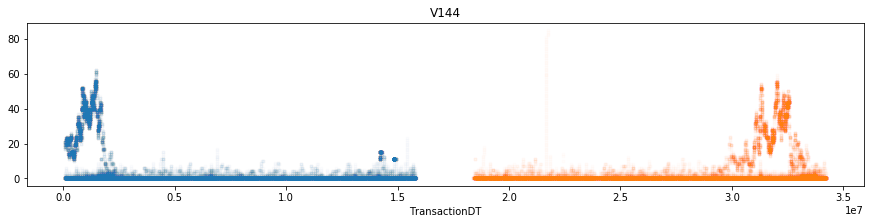

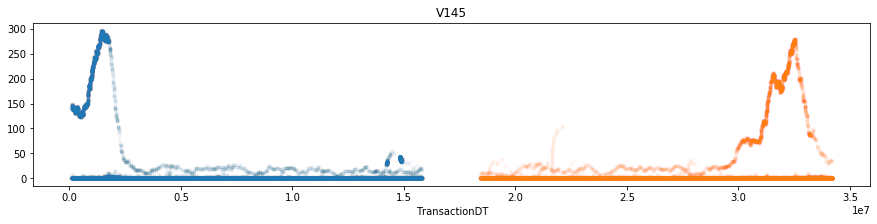

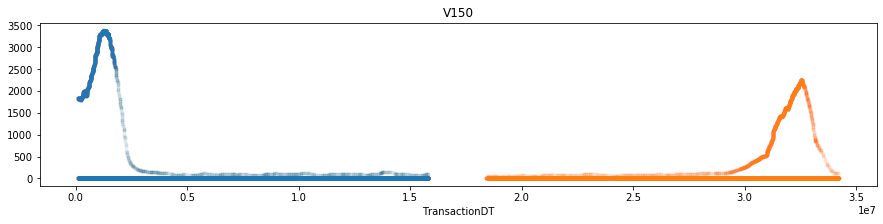

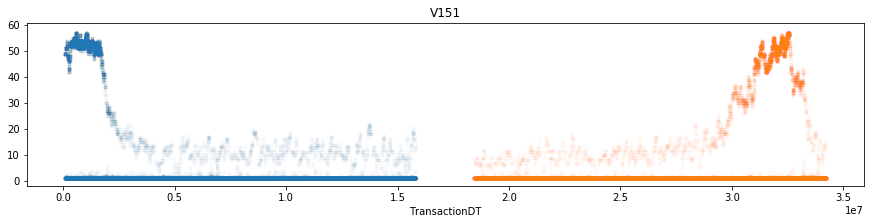

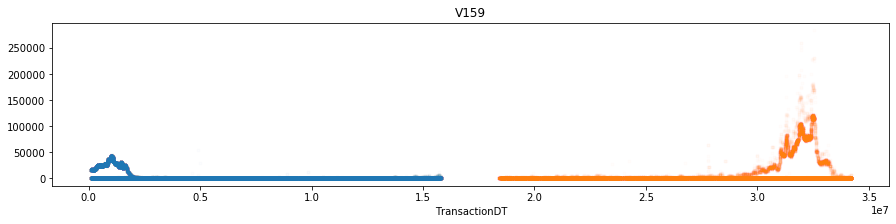

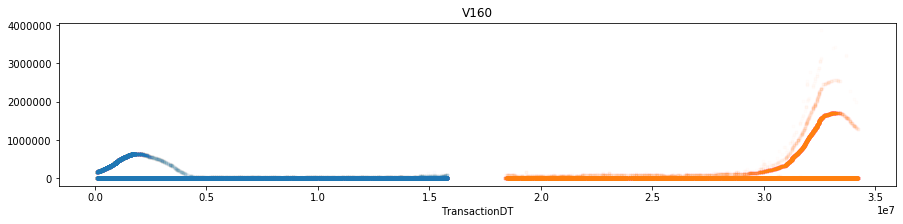

In [18]:
for col in ["C11", "D5", "D8", "D1", "D15", "V144", "V145", "V150", "V151", "V159", "V160"]:
   
        train_transaction.set_index("TransactionDT")[col].plot(style='.', title=col, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index( "TransactionDT")[col].plot(style='.', title=col, figsize=(15, 3), alpha=0.01)
        plt.show()


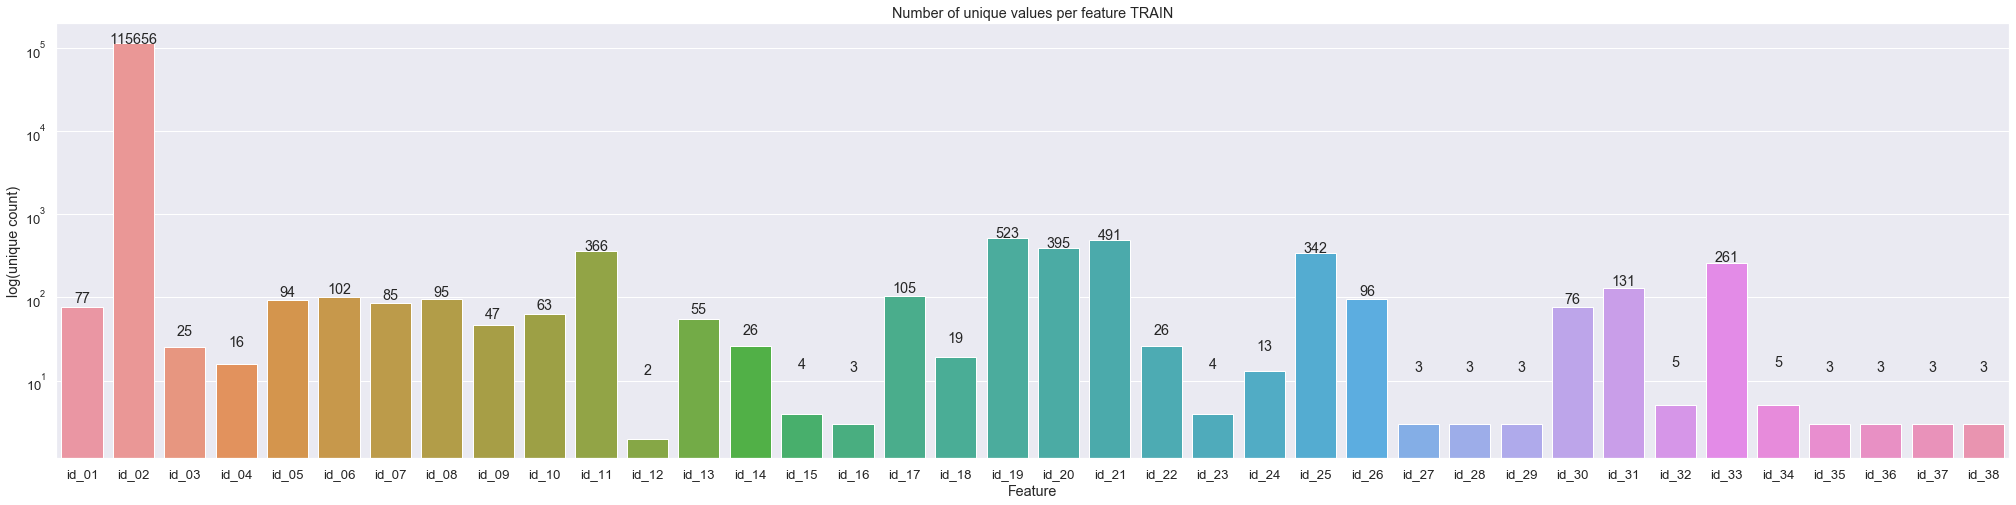

In [19]:
plt.figure(figsize=(35, 8))
features = list(train_identity.columns[0:38])
uniques = [len(train_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 


# PCA 2 components


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

NameError: name 'X_train' is not defined